In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

In [ ]:
df = pd.read_csv("emails.csv")
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


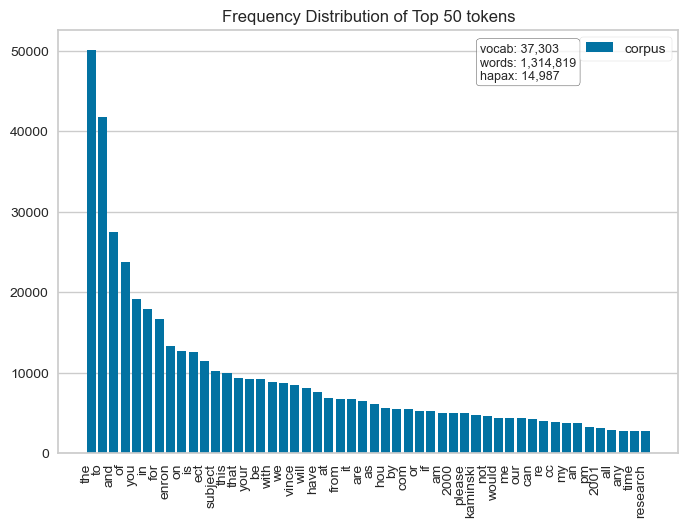

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [3]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [4]:
text = df["text"]
labels = df["spam"]

print(text.shape, labels.shape)

(5728,) (5728,)


In [5]:
# remove digits, @-mentions, links, stopwords

text = text.str.lower()
text = text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
text = text.apply(lambda x : nltk.word_tokenize(x))
text = text.apply(lambda x : " ".join([word for word in x if word not in nltk.corpus.stopwords.words()]))

text.shape

(5728,)

In [6]:
import pickle
with open("text.pkl", "wb") as f:
  pickle.dump(text, f)
with open("labels.pkl", "wb") as f:
  pickle.dump(labels, f)

In [3]:
import pickle
with open("text.pkl", "rb") as f:
  text = pickle.load(f)
with open("labels.pkl", "rb") as f:
  labels = pickle.load(f)

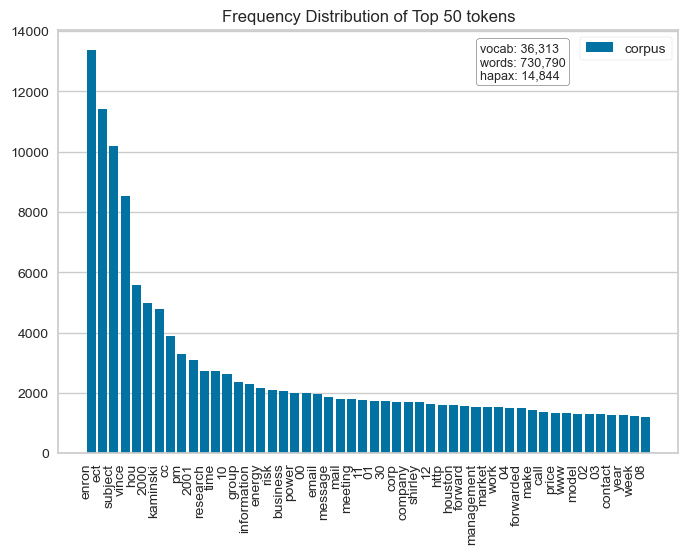

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [30]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(text)
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
lengths = []

X = text
for i in range(len(text)):
  X[i] = tokenizer.tokenize(X[i])
  X[i] = tokenizer.convert_tokens_to_ids(X[i])

for i in range(len(X)):
  lengths.append(len(X[i]))

In [6]:
lengths = np.array(lengths)
X = np.array(X)

print(lengths)
print(len(lengths))
print(np.sum(lengths < 512) / len(lengths))
print(np.sum(lengths < 512))
print(np.max(lengths))

[270 102  58 ... 426 261 327]
5728
0.8837290502793296
5062
6176


In [7]:
lengths = np.array(lengths)
X = np.array(X)

print(np.sum((lengths < 64) & (labels == 1)), np.mean((lengths < 64) & (labels == 1)))
print(np.sum((lengths < 64) & (labels == 0)), np.mean((lengths < 64) & (labels == 0)))

371 0.0647695530726257
786 0.13722067039106145


In [8]:
X_positive = X[(lengths < 64) & (labels == 1)].tolist()
X_negative = X[(lengths < 64) & (labels == 0)].tolist()
X = X_positive[:300] + X_negative[:300]

y_positive = labels[(lengths < 64) & (labels == 1)].tolist()
y_negative = labels[(lengths < 64) & (labels == 0)].tolist()
y = y_positive[:300] + y_negative[:300]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), train_size=500, shuffle=True)

X_test = X_test[:50]
y_test = y_test[:50]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [10]:
import torch

model.config.max_position_embeddings = 64
max_length = model.config.max_position_embeddings

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [11]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.2238, -0.2139, -0.0937,  ..., -0.6627,  0.3024, -0.2404],
         [-0.4468,  0.3267,  0.2392,  ..., -0.5385,  0.3945,  0.4824],
         [-0.2357,  0.7478,  0.5156,  ..., -0.6696,  0.2838,  0.2933],
         ...,
         [-0.1273, -0.3057,  0.0937,  ..., -0.8019,  0.3241, -0.3298],
         [-0.1353, -0.2929,  0.0959,  ..., -0.7974,  0.3367, -0.3291],
         [-0.1245, -0.2674,  0.0868,  ..., -0.7859,  0.3113, -0.3387]],

        [[ 0.2632, -0.0445,  0.5285,  ..., -0.3884,  0.0178, -0.1654],
         [-0.0846, -0.1192,  0.2193,  ..., -0.2041, -0.3045,  0.3460],
         [ 0.0887, -0.1191,  0.2191,  ..., -0.3558, -0.4639,  0.1666],
         ...,
         [ 0.4638, -0.0612,  1.2037,  ..., -0.9476,  0.0173, -0.1807],
         [ 0.4574, -0.0343,  1.2108,  ..., -0.9339,  0.0213, -0.2007],
         [ 0.4792, -0.0197,  1.1979,  ..., -0.9118, -0.0503, -0.2492]],

        [[-0.3897, -0.0582,  0.0777,  ..., -0.8510,  

In [12]:
bert_train_output = bert_train_output[1].detach().numpy().copy()
bert_train_output = bert_train_output.reshape(X_train.shape[0], 768)

In [13]:
bert_test_output = model(X_test_padded)
print(bert_test_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-2.5317e-01, -3.9866e-02,  2.8526e-01,  ..., -8.5647e-01,
           5.2549e-01,  6.9114e-03],
         [-9.5561e-02, -2.3505e-01,  6.7381e-01,  ..., -5.7916e-01,
           4.1826e-01,  6.5259e-02],
         [ 3.1958e-02, -4.3076e-01,  9.0258e-01,  ..., -6.5260e-01,
           4.5290e-01,  2.4721e-01],
         ...,
         [-2.1419e-01,  8.6616e-03,  3.6978e-01,  ..., -9.8719e-01,
           4.5582e-01, -9.0694e-02],
         [-2.1227e-01,  2.7831e-02,  3.8166e-01,  ..., -9.8774e-01,
           4.4241e-01, -1.0551e-01],
         [-2.0639e-01,  3.8168e-02,  3.8537e-01,  ..., -9.7438e-01,
           3.9593e-01, -1.2064e-01]],

        [[-2.0330e-01, -1.5989e-01, -6.6987e-02,  ..., -7.1528e-01,
           7.4484e-01,  1.7295e-02],
         [-2.9518e-01,  4.3164e-01,  5.2560e-01,  ..., -3.6906e-01,
          -3.6768e-02,  3.0022e-01],
         [-3.0033e-01,  5.4958e-01,  5.4673e-01,  ..., -3.6139e-01,
          -2.

In [14]:
bert_test_output = bert_test_output[1].detach().numpy().copy()
bert_test_output = bert_test_output.reshape(X_test.shape[0], 768)

In [15]:
clf = neural_network.MLPClassifier()
clf.fit(bert_train_output, y_train)

MLPClassifier()

In [16]:
print("Train accuracy:", np.mean(clf.predict(bert_train_output) == y_train))
print("Test accuracy:", np.mean(clf.predict(bert_test_output) == y_test))

Train accuracy: 0.936
Test accuracy: 0.88


In [17]:
print(np.unique(y_test))

[0 1]


In [18]:
np.mean(y_test==0)

0.54

In [2]:
shap.initjs()

In [3]:
to_explain = np.array(X_test_padded)[:20]
to_explain.shape

(20, 64)

In [4]:
def prediction_model(X):
  print(type(X), X)
  bert_output = model(torch.from_numpy(np.array(X)).to(torch.int64))
  sequence_output = bert_output[1].detach().numpy()
  return clf.predict(sequence_output.reshape(X.shape[0], 768))

In [5]:
permutation_explainer = shap.explainers.Permutation(prediction_model, to_explain)
#permutation_explainer = shap.explainers.Permutation(clf2.predict, X_test_padded)

In [6]:
permutation_values = permutation_explainer(to_explain)

<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6202. ...    0.    0.    0.]
 [3395. 1024. 3105. ...    0.    0.    0.]
 [3395. 1024. 7628. ...    0.    0.    0.]]


In [ ]:
print(permutation_values)

In [ ]:
for i in range(len(X_test_padded)):
  print("Sentence:", " ".join(tokenizer.convert_ids_to_tokens(X_test_padded[i])).replace(" [PAD]", "") ,"; Prediction:", clf.predict([X_test_padded[i]]), "; True value:", y_test[i])
  shap.plots.force(permutation_values.base_values[i], permutation_values.values[i], permutation_values.data[i], feature_names=tokenizer.convert_ids_to_tokens(permutation_values.data[i]), matplotlib=True)

In [1]:
import dill
filename = 'globalsave.pkl'
# to save the session:
# dill.dump_session(filename)

# and to load the session again:
dill.load_session(filename)